In [1]:
# set work dir if PyEPO is not installed
import os
os.chdir("../pkg")

In [2]:
import time
import random
import pyepo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135) # fix random seed

Auto-Sklearn cannot be imported.


## Problem Defination 

It is a (h,w) grid network and the goal is to find the shortest path from northwest to southeast. In our examples, the grid size of network is (5,5).

![title](../images/shortestpath.png)

## Optimization Model

In [3]:
# grid graph size
grid = (5,5)
# set random cost for test
cost = [random.random() for _ in range(40)]

### Model 1: Pre-defined Gurobi Model

In [4]:
# PyEPO contains several pre-defined optimization models with GurobiPy and Pyomo.
# Use pre-defined shortest path model

from pyepo.model.grb import shortestPathModel

# solve model
myoptmodel = shortestPathModel(grid) # init model
myoptmodel.setObj(cost) # set objective function
sol, obj = myoptmodel.solve() # solve
# print res
print('Obj: {}'.format(obj))
for i, e in enumerate(myoptmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-07-15
Obj: 3.095222122793223
(0, 1)
(1, 2)
(2, 3)
(3, 8)
(8, 9)
(9, 14)
(14, 19)
(19, 24)


### Model 2: Dijkstra Agorithm Solver on NetworkX

In [5]:
import networkx as nx

from pyepo.model.opt import optModel

class myShortestPathModel(optModel):

    def __init__(self, grid):
        """
        Args:
            grid (tuple): size of grid network
        """
        self.grid = grid
        self.arcs = self._getArcs()
        super().__init__()

    def _getArcs(self):
        """
        A method to get list of arcs for grid network

        Returns:
            list: arcs
        """
        arcs = []
        for i in range(self.grid[0]):
            # edges on rows
            for j in range(self.grid[1] - 1):
                v = i * self.grid[1] + j
                arcs.append((v, v + 1))
            # edges in columns
            if i == self.grid[0] - 1:
                continue
            for j in range(self.grid[1]):
                v = i * self.grid[1] + j
                arcs.append((v, v + self.grid[1]))
        return arcs

    def _getModel(self):
        """
        A method to build model

        Returns:
            tuple: optimization model and variables
        """
        # build graph as optimization model
        g = nx.Graph()
        # add arcs as variables
        g.add_edges_from(self.arcs, cost=0)
        return g, g.edges

    def setObj(self, c):
        """
        A method to set objective function

        Args:
            c (ndarray): cost of objective function
        """
        for i, e in enumerate(self.arcs):
            self._model.edges[e]["cost"] = c[i]

    def solve(self):
        """
        A method to solve model

        Returns:
            tuple: optimal solution (list) and objective value (float)
        """
        # dijkstra
        path = nx.shortest_path(self._model, weight="cost", source=0, target=self.grid[0]*self.grid[1]-1)
        # convert path into active edges
        edges = []
        u = 0
        for v in path[1:]:
            edges.append((u,v))
            u = v
        # init sol & obj
        sol = np.zeros(self.num_cost)
        obj = 0
        # convert active edges into solution and obj
        for i, e in enumerate(self.arcs):
            if e in edges:
                sol[i] = 1 # active edge
                obj += self._model.edges[e]["cost"] # cost of active edge
        return sol, obj

In [6]:
# solve model
myoptmodel = myShortestPathModel(grid) # init model
myoptmodel.setObj(cost) # set objective function
sol, obj = myoptmodel.solve() # solve
# print res
print('Obj: {}'.format(obj))
for i, e in enumerate(myoptmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 3.095222122793223
(0, 1)
(1, 2)
(2, 3)
(3, 8)
(8, 9)
(9, 14)
(14, 19)
(19, 24)


### Model 3: Linear Programming on Gurobi

In [7]:
# We can use optGrbModel with Gurobi to create a LP model

import gurobipy as gp
from gurobipy import GRB
from pyepo.model.grb import optGrbModel

class myShortestPathModel(optGrbModel):

    def __init__(self, grid):
        """
        Args:
            grid (tuple of int): size of grid network
        """
        self.grid = grid
        self.arcs = self._getArcs()
        super().__init__()

    def _getArcs(self):
        """
        A method to get list of arcs for grid network

        Returns:
            list: arcs
        """
        arcs = []
        for i in range(self.grid[0]):
            # edges on rows
            for j in range(self.grid[1] - 1):
                v = i * self.grid[1] + j
                arcs.append((v, v + 1))
            # edges in columns
            if i == self.grid[0] - 1:
                continue
            for j in range(self.grid[1]):
                v = i * self.grid[1] + j
                arcs.append((v, v + self.grid[1]))
        return arcs

    def _getModel(self):
        """
        A method to build Gurobi model

        Returns:
            tuple: optimization model and variables
        """
        # ceate a model
        m = gp.Model("shortest path")
        # varibles
        x = m.addVars(self.arcs, name="x")
        # sense
        m.modelSense = GRB.MINIMIZE
        # constraints
        for i in range(self.grid[0]):
            for j in range(self.grid[1]):
                v = i * self.grid[1] + j
                expr = 0
                for e in self.arcs:
                    # flow in
                    if v == e[1]:
                        expr += x[e]
                    # flow out
                    elif v == e[0]:
                        expr -= x[e]
                # source
                if i == 0 and j == 0:
                    m.addConstr(expr == -1)
                # sink
                elif i == self.grid[0] - 1 and j == self.grid[0] - 1:
                    m.addConstr(expr == 1)
                # transition
                else:
                    m.addConstr(expr == 0)
        return m, x

In [8]:
# solve model
myoptmodel = myShortestPathModel(grid) # init model
myoptmodel.setObj(cost) # set objective function
sol, obj = myoptmodel.solve() # solve
# print res
print('Obj: {}'.format(obj))
for i, e in enumerate(myoptmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 3.095222122793223
(0, 1)
(1, 2)
(2, 3)
(3, 8)
(8, 9)
(9, 14)
(14, 19)
(19, 24)


## Init Data for Shortest Path 

pyepo.data contains synthetic data generator and a dataset class optDataset to wrap data samples. See details of parameters and data generation in our documentation [link](https://khalil-research.github.io/PyEPO/build/html/content/examples/data.html).

In [9]:
# generate data for grid network (features and costs)
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
feats, costs = pyepo.data.shortestpath.genData(n+1000, p, grid, deg=deg)

In [10]:
# features
feats

array([[ 0.18978013,  0.28131239,  0.80407457,  0.34358466,  0.79699536],
       [-0.89260884,  0.22798708,  0.40622607,  0.20233536,  0.44483962],
       [ 0.09901204,  0.69809107, -0.25065277,  0.08962057,  0.7150901 ],
       ...,
       [-0.80436654,  0.25590744, -0.14672173, -0.41275959,  1.28220286],
       [ 0.20511618, -1.79636601,  1.55571123,  0.11183987, -0.56605091],
       [ 0.35470335, -0.90784318, -0.384665  ,  0.20299626,  0.20231918]])

In [11]:
# cost coefficients
costs

array([[1.1196807 , 1.45837107, 0.54643898, ..., 0.98651383, 0.99008207,
        0.85559908],
       [0.47167426, 0.9868889 , 0.54643898, ..., 0.79780845, 0.78138255,
        0.68954997],
       [0.90154675, 1.02959971, 0.54643898, ..., 1.16626396, 0.70551119,
        0.47017403],
       ...,
       [0.56769133, 1.15386747, 0.54643898, ..., 1.23927857, 0.5824488 ,
        0.50074203],
       [0.47062148, 0.32998715, 0.54643898, ..., 0.10173785, 0.47305124,
        1.24983587],
       [0.83585924, 0.27219742, 0.54643898, ..., 0.35273756, 0.23596431,
        0.43287876]])

In [12]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=246)

In [13]:
# get optDataest by computing optimal solution for each cost vector
dataset_train = pyepo.data.dataset.optDataset(myoptmodel, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(myoptmodel, x_test, c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1108.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1105.94it/s]


In [14]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Linear Regression from PyTorch 

In [15]:
from torch import nn

# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+

SPO+ loss function, a surrogate loss function of SPO Loss, measures the decision error (optimality gap) of optimization problem.

In [16]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [17]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [18]:
# init SPO+ loss
processes = 1 # It is the number of processes running the solver. jupyter notebook cannot support multiple processes for PyEPO.
criterion = pyepo.func.SPOPlus(myoptmodel, processes=processes)

Num of cores: 1


In [19]:
# train model
num_epochs = 100
reg.train()
loss_log = []
loss_log_regret = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    # log
    if (epoch + 1) % 5 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, myoptmodel, loader_test)
        loss_log_regret.append(trueloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), trueloss*100))

Epoch   5, Loss:   0.4584, Regret:  2.0948%
Epoch  10, Loss:   0.7858, Regret:  1.1483%
Epoch  15, Loss:   0.0677, Regret:  1.3117%
Epoch  20, Loss:   0.2380, Regret:  0.9775%
Epoch  25, Loss:   0.3794, Regret:  1.6157%
Epoch  30, Loss:   0.4783, Regret:  1.4895%
Epoch  35, Loss:   0.4598, Regret:  1.2882%
Epoch  40, Loss:   0.0000, Regret:  1.2004%
Epoch  45, Loss:   0.2694, Regret:  1.3773%
Epoch  50, Loss:   0.2516, Regret:  1.2898%
Epoch  55, Loss:   0.9350, Regret:  1.5030%
Epoch  60, Loss:   1.1951, Regret:  1.3418%
Epoch  65, Loss:   0.1074, Regret:  1.3033%
Epoch  70, Loss:   0.0188, Regret:  1.0445%
Epoch  75, Loss:   0.2000, Regret:  1.0524%
Epoch  80, Loss:   0.3184, Regret:  1.0797%
Epoch  85, Loss:   0.1184, Regret:  0.9101%
Epoch  90, Loss:   0.2203, Regret:  0.8660%
Epoch  95, Loss:   0.1344, Regret:  0.7857%
Epoch 100, Loss:   0.4297, Regret:  0.9709%


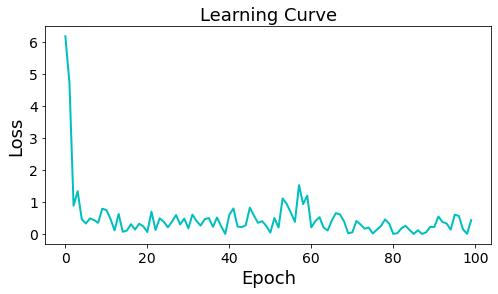

In [20]:
# draw plot for training loss
plt.figure(figsize=(8, 4))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.title("Learning Curve", fontsize=18)
plt.show()

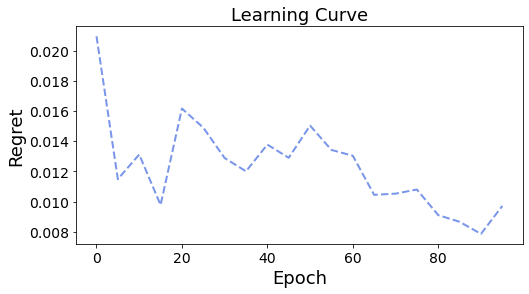

In [21]:
# draw plot for regret on test
fig = plt.figure(figsize=(8, 4))
plt.plot(range(0, num_epochs, 5), loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Regret", fontsize=18)
plt.title("Learning Curve", fontsize=18)
plt.show()

## DBB 

Diffenretiable black-box (DBB) optimizer function introduces optimizer block into neural networks.

In [22]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [23]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [24]:
# set loss
criterion = nn.L1Loss()
dbb = pyepo.func.blackboxOpt(myoptmodel, lambd=20, processes=1)

Num of cores: 1


In [25]:
# train model
num_epochs = 100
reg.train()
loss_log = []
loss_log_regret = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = dbb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 5 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, myoptmodel, loader_test)
        loss_log_regret.append(trueloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), trueloss*100))

Epoch   5, Loss:   0.7079, Regret: 22.9946%
Epoch  10, Loss:   0.4344, Regret: 12.5924%
Epoch  15, Loss:   0.1229, Regret:  9.0142%
Epoch  20, Loss:   0.2752, Regret:  7.2931%
Epoch  25, Loss:   0.1990, Regret:  7.2955%
Epoch  30, Loss:   0.9740, Regret:  6.5897%
Epoch  35, Loss:   0.1536, Regret:  6.2912%
Epoch  40, Loss:   0.1519, Regret:  9.6355%
Epoch  45, Loss:   0.8076, Regret: 10.5425%
Epoch  50, Loss:   0.4807, Regret: 11.7479%
Epoch  55, Loss:   0.2371, Regret:  9.3480%
Epoch  60, Loss:   1.0383, Regret: 11.9264%
Epoch  65, Loss:   0.0447, Regret: 10.9006%
Epoch  70, Loss:   0.3675, Regret:  4.1474%
Epoch  75, Loss:   0.0837, Regret:  6.3551%
Epoch  80, Loss:   0.1139, Regret: 10.8714%
Epoch  85, Loss:   1.1622, Regret:  8.4804%
Epoch  90, Loss:   0.3997, Regret:  6.7428%
Epoch  95, Loss:   0.2559, Regret:  6.7810%
Epoch 100, Loss:   0.2556, Regret:  7.7663%


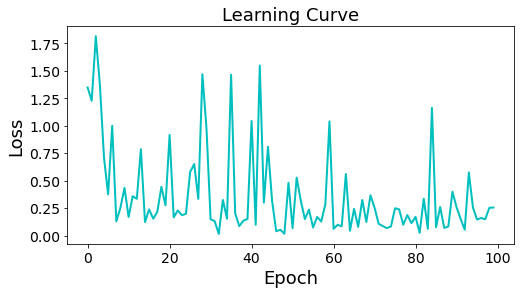

In [26]:
# draw plot for training loss
plt.figure(figsize=(8, 4))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.title("Learning Curve", fontsize=18)
plt.show()

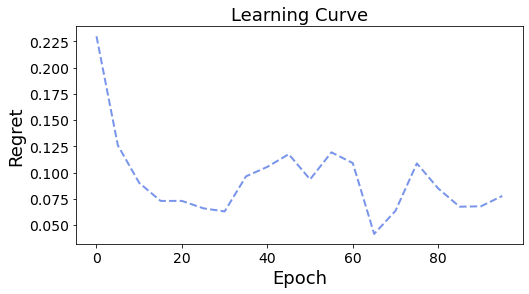

In [27]:
# draw plot for regret on test
fig = plt.figure(figsize=(8, 4))
plt.plot(range(0, num_epochs, 5), loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Regret", fontsize=18)
plt.title("Learning Curve", fontsize=18)
plt.show()